In [3]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [8]:
def assign_labels(battery, mode):
    processed_dfs = []

    folder_path = f"../data/NASA data/{mode}/{battery}"  
    save_path = f"../data/NASA data/labeled/{mode}/{battery}"
    os.makedirs(save_path, exist_ok=True)

    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"Error: The folder '{folder_path}' does not exist.")
    else:
        # Iterate through all files in the folder
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path).copy()

            # Find first index where voltage drops below 2.7V   
            cutoff_idx = df[df['Voltage_measured'] < 2.7].index.min()
            truncated_df = df if pd.isna(cutoff_idx) else df.iloc[:cutoff_idx].copy()

            # Calculate capacity
            truncated_df['Time_diff_hr'] = truncated_df['Time'].diff().fillna(0) / 3600
            truncated_df['Delta_Q'] = truncated_df['Current_measured'] * truncated_df['Time_diff_hr']
            capacity = abs(truncated_df['Delta_Q'].sum())
        
            # Only use cycles with capacity above threshold (filter out bad data)
            if capacity > 1.4:
                # Calculate SoC using coulomb counting
                truncated_df['Cumulative_Q'] = truncated_df['Delta_Q'].cumsum()
                
                if mode == 'charge':
                    truncated_df['SoC'] = 100 * (truncated_df['Cumulative_Q'] / capacity)
                elif mode == 'discharge':
                    truncated_df['SoC'] = 100 * (1 + truncated_df['Cumulative_Q'] / capacity)

                # Calculate SoH as percentage of nominal capacity (2.0 Ah)
                soh_value = (capacity / 2.0) * 100
                truncated_df['SoH'] = soh_value

                # prepare dataframe for saving
                cycle = truncated_df["id_cycle"].iloc[0]
                battery_file = os.path.join(save_path, f'{battery}_{cycle}.csv')
                truncated_df.drop(['time', 'type', 'id_cycle',
                                    'Time_diff_hr', 'Delta_Q',
                                    'Cumulative_Q',
                                    'ambient_temperature'], axis=1, inplace=True)
                
                # save the csv file
                # truncated_df.to_csv(battery_file, index=False)
            processed_dfs.append(truncated_df)

        print(f"Save {battery} {mode}")

    # Combine all processed data
    if processed_dfs:
        full_dataset = pd.concat(processed_dfs)
        # full_dataset.sort_values(['id_cycle', 'Time'], ascending=True, inplace=True)
        # print(f"Final dataset shape: {full_dataset.shape}")
        # full_dataset.to_csv("battery_health_dataset.csv", index=False)
        return full_dataset
    return
        

In [9]:
for battery in ['B0005', 'B0006', 'B0007', 'B0018',
                'B0025', 'B0026', 'B0027', 'B0028',
                'B0029', 'B0030', 'B0031', 'B0032',
                'B0033', 'B0034', 'B0036',
                'B0038', 'B0039', 'B0040',
                'B0041', 'B0042', 'B0043', 'B0044',
                'B0045', 'B0046', 'B0047', 'B0048',
                'B0049', 'B0050', 'B0051', 'B0052',
                'B0053', 'B0054', 'B0055', 'B0056']:
    for mode in ['charge', 'discharge']:
        assign_labels(battery, mode)

Save B0005 charge
Save B0005 discharge
Save B0006 charge
Save B0006 discharge
Save B0007 charge
Save B0007 discharge
Save B0018 charge
Save B0018 discharge
Save B0025 charge
Save B0025 discharge
Save B0026 charge
Save B0026 discharge
Save B0027 charge
Save B0027 discharge
Save B0028 charge
Save B0028 discharge
Save B0029 charge
Save B0029 discharge
Save B0030 charge
Save B0030 discharge
Save B0031 charge
Save B0031 discharge
Save B0032 charge
Save B0032 discharge
Save B0033 charge
Save B0033 discharge
Save B0034 charge
Save B0034 discharge
Save B0036 charge
Save B0036 discharge
Save B0038 charge
Save B0038 discharge
Save B0039 charge
Save B0039 discharge
Save B0040 charge
Save B0040 discharge
Save B0041 charge
Save B0041 discharge
Save B0042 charge
Save B0042 discharge
Save B0043 charge
Save B0043 discharge
Save B0044 charge
Save B0044 discharge
Save B0045 charge
Save B0045 discharge
Save B0046 charge
Save B0046 discharge
Save B0047 charge
Save B0047 discharge
Save B0048 charge
Save B0

In [10]:
full_dataset = assign_labels("B0056", 'discharge')

Save B0056 discharge


In [11]:
full_dataset

,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time,Capacity,id_cycle,type,ambient_temperature,time,Time_diff_hr,Delta_Q
0,4.179855,-0.001325,6.441212,0.0004,0.000,0.000,1.191488,36,discharge,4,2010.0,0.000000,-0.000000
1,4.179642,-0.002211,6.458378,0.0004,4.195,9.328,1.191488,36,discharge,4,2010.0,0.002591,-0.000006
2,3.803935,-1.995636,6.485863,1.9982,2.703,20.234,1.191488,36,discharge,4,2010.0,0.003029,-0.006046
3,3.779757,-1.996548,6.553802,1.9982,2.688,30.390,1.191488,36,discharge,4,2010.0,0.002821,-0.005632
4,3.760699,-1.992419,6.633206,1.9982,2.676,40.515,1.191488,36,discharge,4,2010.0,0.002812,-0.005604
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,2.779476,-1.995585,12.904542,1.9982,1.730,2083.891,1.176396,88,discharge,4,2010.0,0.003060,-0.006106
189,2.762860,-1.995867,12.705635,1.9982,1.714,2094.969,1.176396,88,discharge,4,2010.0,0.003077,-0.006142
190,2.745945,-1.995380,12.679477,1.9982,1.697,2106.000,1.176396,88,discharge,4,2010.0,0.003064,-0.006114
191,2.728214,-1.994488,12.661671,1.9982,1.679,2117.032,1.176396,88,discharge,4,2010.0,0.003064,-0.006112


In [45]:
full_dataset[full_dataset['id_cycle'].isin([6])]


,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time,Capacity,id_cycle,type,ambient_temperature,time,Time_diff_hr,Delta_Q,Cumulative_Q,SoC,SoH
0,4.175334,0.000063,6.309524,0.0004,0.000,0.000,1.317503,6,discharge,4,2010.0,0.000000,0.000000e+00,0.000000e+00,100.000000,65.752042
1,4.175131,-0.000287,6.322307,0.0004,4.191,9.391,1.317503,6,discharge,4,2010.0,0.002609,-7.477957e-07,-7.477957e-07,99.999943,65.752042
2,3.765890,-1.993009,6.348879,1.9982,2.646,19.688,1.317503,6,discharge,4,2010.0,0.002860,-5.700560e-03,-5.701308e-03,99.566454,65.752042
3,3.741450,-1.994438,6.416528,1.9982,2.636,29.250,1.317503,6,discharge,4,2010.0,0.002656,-5.297448e-03,-1.099876e-02,99.163619,65.752042
4,3.721587,-1.994228,6.504555,1.9982,2.622,38.719,1.317503,6,discharge,4,2010.0,0.002630,-5.245374e-03,-1.624413e-02,98.764743,65.752042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2.756048,-1.995030,14.441603,1.9982,1.706,2345.860,1.317503,6,discharge,4,2010.0,0.002665,-5.316756e-03,-1.293740e+00,1.619760,65.752042
248,2.744832,-1.992448,14.600926,1.9982,1.695,2355.500,1.317503,6,discharge,4,2010.0,0.002678,-5.335333e-03,-1.299076e+00,1.214044,65.752042
249,2.733750,-1.992645,14.698218,1.9984,1.684,2365.125,1.317503,6,discharge,4,2010.0,0.002674,-5.327557e-03,-1.304403e+00,0.808919,65.752042
250,2.722310,-1.994170,14.726088,1.9982,1.672,2374.735,1.317503,6,discharge,4,2010.0,0.002669,-5.323326e-03,-1.309727e+00,0.404116,65.752042


In [46]:
full_dataset.head()

,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time,Capacity,id_cycle,type,ambient_temperature,time,Time_diff_hr,Delta_Q,Cumulative_Q,SoC,SoH
0,3.838723,-0.001189,6.293379,0.0004,0.000,0.000,0.785278,0,discharge,4,2010.0,0.000000,-0.000000e+00,-0.000000e+00,100.000000,39.144166
1,3.838476,0.000195,6.307099,0.0004,3.853,9.438,0.785278,0,discharge,4,2010.0,0.002622,5.108140e-07,5.108140e-07,100.000065,39.144166
2,3.309743,-1.993708,6.355489,1.9982,2.183,19.578,0.785278,0,discharge,4,2010.0,0.002817,-5.615611e-03,-5.615100e-03,99.282767,39.144166
3,3.280056,-1.993404,6.439268,1.9982,2.175,28.938,0.785278,0,discharge,4,2010.0,0.002600,-5.182850e-03,-1.079795e-02,98.620746,39.144166
4,3.255598,-1.994241,6.561227,1.9982,2.156,38.281,0.785278,0,discharge,4,2010.0,0.002595,-5.175610e-03,-1.597356e-02,97.959650,39.144166


Text(0.5, 1.0, 'Discharge')

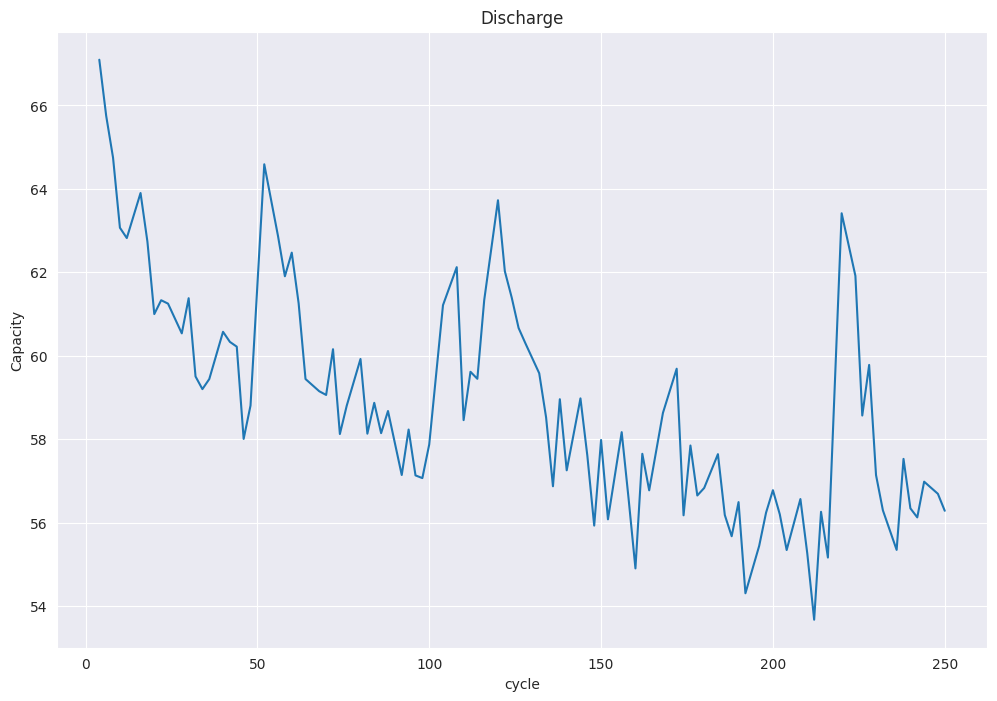

In [47]:
plot_df = full_dataset.loc[(full_dataset['id_cycle']>=1),['id_cycle','SoH']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['id_cycle'], plot_df['SoH'])
#Draw threshold
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title(f'Discharge')

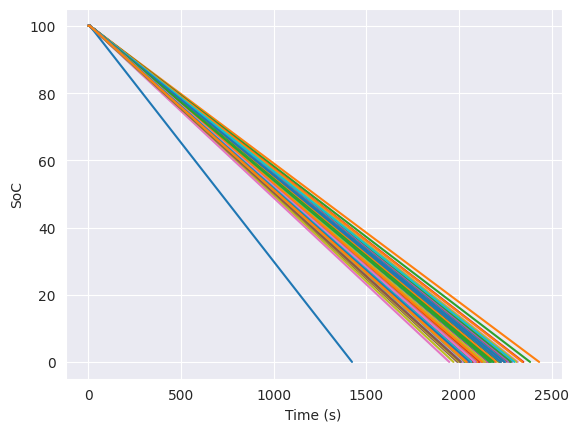

In [48]:
# SoC Over Time by Cycle
for cycle in full_dataset['id_cycle'].unique():
    data = full_dataset[full_dataset['id_cycle'] == cycle]
    plt.plot(data["Time"], data["SoC"], '-')
    plt.ylabel('SoC')
    plt.xlabel('Time (s)')
plt.show()
